# Hugging Face AI Agents Course - Final Assignment

## Imports

In [1]:
# Agent Building
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage, SystemMessage

# AI Models
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI

# Tools
from langchain_tavily import TavilySearch

# Misc
import requests
from dotenv import load_dotenv
from IPython.display import Image, display
from pydantic import BaseModel, Field
from typing import Literal

load_dotenv()

True

## Agent Building

### Classes for Input, Output and State

In [2]:
# Define how the output of the agent should look like
class FinalResponseOutput(BaseModel):
    """Respond to the user with this"""

    final_reponse: str = Field(
        description="your answer with the following template: FINAL ANSWER: [YOUR FINAL ANSWER]. YOUR FINAL ANSWER should be a number OR as few words as possible OR a comma separated list of numbers and/or strings."
    )
    reasoning_trace: str = Field("The different steps by which you reached answer")


# Agent State
class AgentState(MessagesState):
    final_response: FinalResponseOutput

### Tools

In [3]:
search = TavilySearch(max_results=5)

tools = [search]

### LLM Model

In [9]:
# llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-lite", temperature=0)
llm = ChatOpenAI(model="gpt-4.1-nano", temperature=0)
llm_with_tools = llm.bind_tools(
    tools
)
llm_with_structured_output = llm.with_structured_output(FinalResponseOutput, method="function_calling")

### Graph

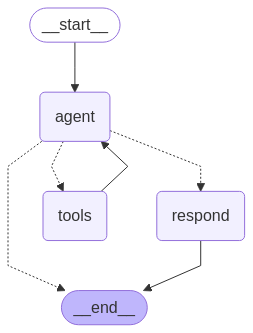

In [10]:
# Define the system message to respond in the GAIA Benchmark format
sys_msg = SystemMessage(
    content="You are a general AI assistant. I will ask you a question. Report your thoughts, and finish your answer with the following template: FINAL ANSWER: [YOUR FINAL ANSWER]. YOUR FINAL ANSWER should be a number OR as few words as possible OR a comma separated list of numbers and/or strings. If you are asked for a number, don't use comma to write your number neither use units such as $ or percent sign unless specified otherwise. If you are asked for a string, don't use articles, neither abbreviations (e.g. for cities), and write the digits in plain text unless specified otherwise. If you are asked for a comma separated list, apply the above rules depending of whether the element to be put in the list is a number or a string."
)


# Define the function that calls the model
def call_model(state: AgentState):
    response = llm_with_tools.invoke(state["messages"])
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define the function that responds to the user
def respond(state: AgentState):
    # We call the model with structured output in order to return the same format to the user every time
    # state['messages'][-2] is the last ToolMessage in the convo, which we convert to a HumanMessage for the model to use
    # We could also pass the entire chat history, but this saves tokens since all we care to structure is the output of the tool
    response = llm_with_structured_output.invoke([sys_msg] + state["messages"])
    # We return the final answer
    return {"final_response": response}


# Define the function that determines whether to continue or not
def should_continue(state: AgentState) -> Literal["tools", "respond"]:
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we respond to the user
    if not last_message.tool_calls:
        return "respond"
    # Otherwise if there is, we continue
    else:
        return "tools"


# Define a new graph
workflow = StateGraph(AgentState)

### Nodes
workflow.add_node("agent", call_model)
workflow.add_node("respond", respond)
workflow.add_node("tools", ToolNode(tools))

### Edges
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    "agent",
    should_continue,
)

workflow.add_edge("tools", "agent")
workflow.add_edge("respond", END)
graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

## Testing

In [7]:
# Gets a random question from the API
response_json = requests.get(
    "https://agents-course-unit4-scoring.hf.space/random-question"
).json()
question = response_json["question"]

# Shows each json field
print("Question:", question)
print("Level", response_json["Level"])
print("File name:", response_json["file_name"])

Question: I'm making a grocery list for my mom, but she's a professor of botany and she's a real stickler when it comes to categorizing things. I need to add different foods to different categories on the grocery list, but if I make a mistake, she won't buy anything inserted in the wrong category. Here's the list I have so far:

milk, eggs, flour, whole bean coffee, Oreos, sweet potatoes, fresh basil, plums, green beans, rice, corn, bell pepper, whole allspice, acorns, broccoli, celery, zucchini, lettuce, peanuts

I need to make headings for the fruits and vegetables. Could you please create a list of just the vegetables from my list? If you could do that, then I can figure out how to categorize the rest of the list into the appropriate categories. But remember that my mom is a real stickler, so make sure that no botanical fruits end up on the vegetable list, or she won't get them when she's at the store. Please alphabetize the list of vegetables, and place each item in a comma separat

In [11]:
# Process the question with the agent
messages = [HumanMessage(content=question)]
messages = graph.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

print("Final response:", messages["final_response"].final_reponse)

================================ Human Message =================================

I'm making a grocery list for my mom, but she's a professor of botany and she's a real stickler when it comes to categorizing things. I need to add different foods to different categories on the grocery list, but if I make a mistake, she won't buy anything inserted in the wrong category. Here's the list I have so far:

milk, eggs, flour, whole bean coffee, Oreos, sweet potatoes, fresh basil, plums, green beans, rice, corn, bell pepper, whole allspice, acorns, broccoli, celery, zucchini, lettuce, peanuts

I need to make headings for the fruits and vegetables. Could you please create a list of just the vegetables from my list? If you could do that, then I can figure out how to categorize the rest of the list into the appropriate categories. But remember that my mom is a real stickler, so make sure that no botanical fruits end up on the vegetable list, or she won't get them when she's at the store. Please al